In [ ]:
# loan_approval_prediction.ipynb

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('ggplot')
sns.set_palette("Set2")

In [ ]:
df = pd.read_csv('/content/loan_approval_dataset.csv')
print(df.shape)
df.head()

(4269, 13)


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [ ]:
# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (4269, 13)

First 5 rows:
   loan_id   no_of_dependents      education  self_employed   income_annum  \
0        1                  2       Graduate             No        9600000   
1        2                  0   Not Graduate            Yes        4100000   
2        3                  3       Graduate             No        9100000   
3        4                  3       Graduate             No        8200000   
4        5                  5   Not Graduate            Yes        9800000   

    loan_amount   loan_term   cibil_score   residential_assets_value  \
0      29900000          12           778                    2400000   
1      12200000           8           417                    2700000   
2      29700000          20           506                    7100000   
3      30700000           8           467                   18200000   
4      24200000          20           382                   12400000   

    commercial_assets_value   luxury_assets_value   bank_

In [ ]:
# Handle missing values
def preprocess_data(df):
    # Create a copy of the dataframe
    df_processed = df.copy()

    # Fill missing values
    # For numerical columns, use median
    num_cols = [' loan_amount', ' loan_term', ' cibil_score'] # Corrected column names
    for col in num_cols:
        # Check if the column exists before filling missing values
        if col in df_processed.columns:
            df_processed[col].fillna(df_processed[col].median(), inplace=True)
        else:
            print(f"Warning: Column '{col}' not found in the DataFrame.")


    # For categorical columns, use mode
    cat_cols = [' education', ' self_employed', ' loan_status'] # Corrected column names, added space before loan_status
    for col in cat_cols:
         # Check if the column exists before filling missing values
        if col in df_processed.columns:
            df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)
        else:
            print(f"Warning: Column '{col}' not found in the DataFrame.")


    # Convert categorical variables to numerical
    label_encoders = {}
    categorical_columns = [' education', ' self_employed', ' loan_status'] # Corrected column names, added space before loan_status

    for col in categorical_columns:
        # Check if the column exists before encoding
        if col in df_processed.columns:
            le = LabelEncoder()
            df_processed[col] = le.fit_transform(df_processed[col])
            label_encoders[col] = le
        else:
            print(f"Warning: Column '{col}' not found in the DataFrame. Skipping encoding.")


    # Feature engineering: Create new features
    # Total income (Applicant + Coapplicant)
    # Corrected column names
    df_processed['Total_Income'] = df_processed[' income_annum']

    # EMI (Estimated monthly installment)
    # Assuming interest rate of 8.5% per annum
    # Corrected column names
    df_processed['EMI'] = df_processed[' loan_amount'] * 0.085 * (1 + 0.085) ** df_processed[' loan_term'] / \
                         ((1 + 0.085) ** df_processed[' loan_term'] - 1)

    # Income to EMI ratio
    df_processed['Income_to_EMI'] = df_processed['Total_Income'] / (df_processed['EMI'] + 1)  # +1 to avoid division by zero

    # Loan amount to income ratio
    df_processed['Loan_to_Income'] = df_processed[' loan_amount'] / (df_processed['Total_Income'] + 1)

    return df_processed, label_encoders

# Preprocess the data
df_processed, label_encoders = preprocess_data(df)

# Display processed data info
print("Processed Dataset Shape:", df_processed.shape)
print("\nProcessed Data Info:")
print(df_processed.info())
print("\nMissing Values after preprocessing:")
print(df_processed.isnull().sum())

Processed Dataset Shape: (4269, 17)

Processed Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   loan_id                    4269 non-null   int64  
 1    no_of_dependents          4269 non-null   int64  
 2    education                 4269 non-null   int64  
 3    self_employed             4269 non-null   int64  
 4    income_annum              4269 non-null   int64  
 5    loan_amount               4269 non-null   int64  
 6    loan_term                 4269 non-null   int64  
 7    cibil_score               4269 non-null   int64  
 8    residential_assets_value  4269 non-null   int64  
 9    commercial_assets_value   4269 non-null   int64  
 10   luxury_assets_value       4269 non-null   int64  
 11   bank_asset_value          4269 non-null   int64  
 12   loan_status               4269 non-null   int

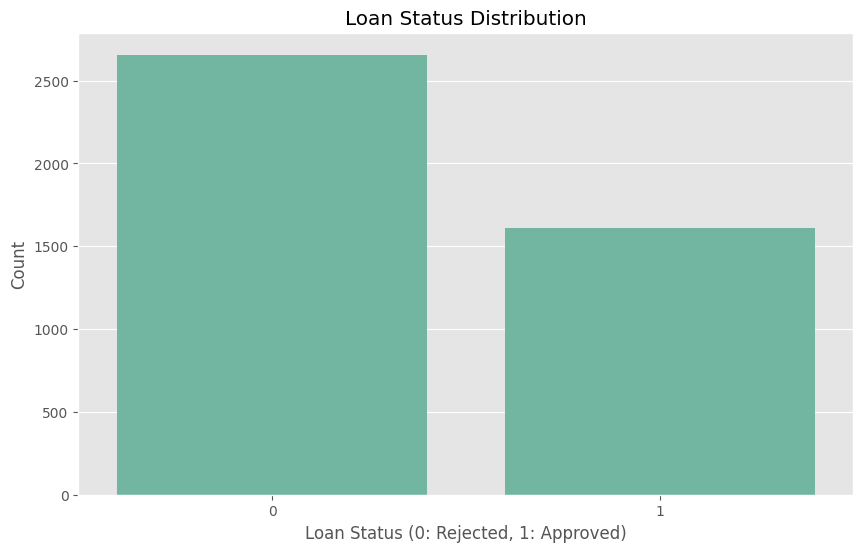

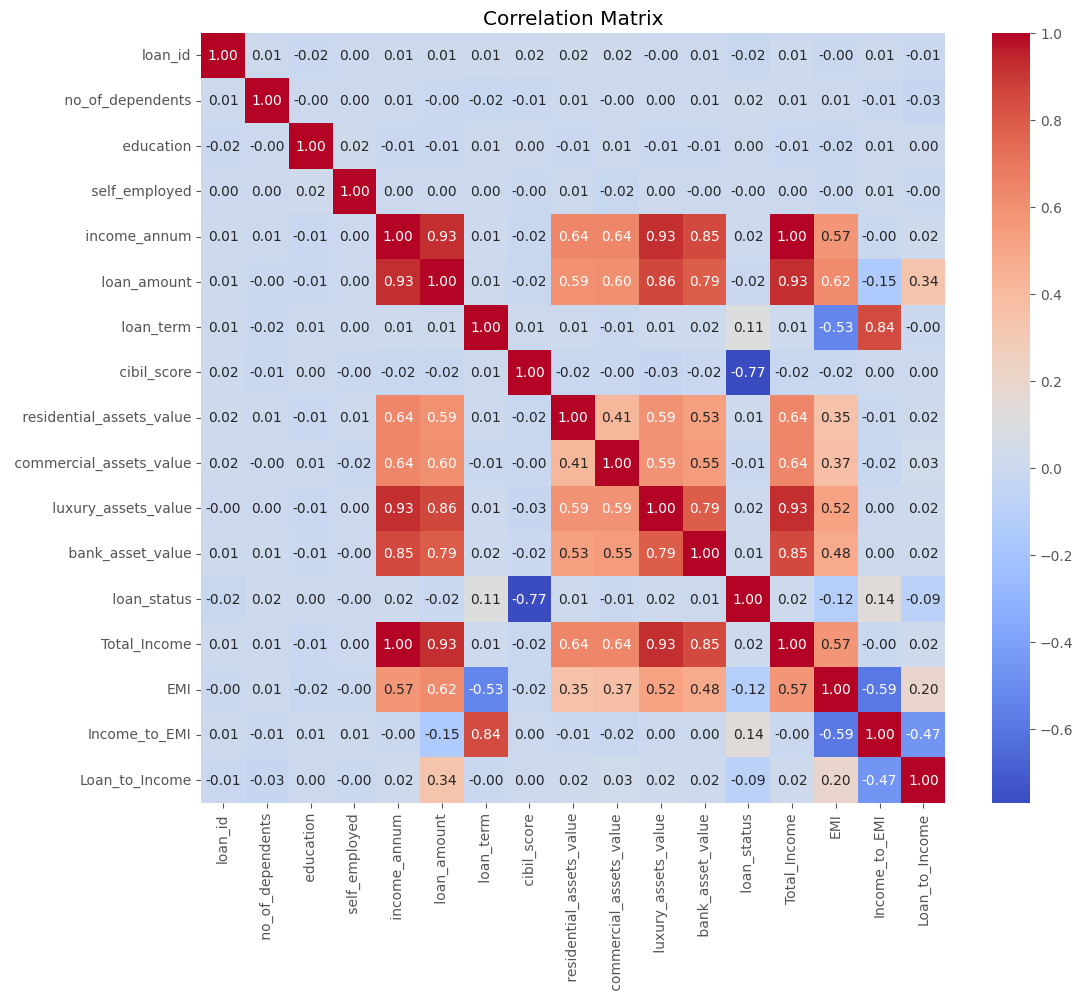

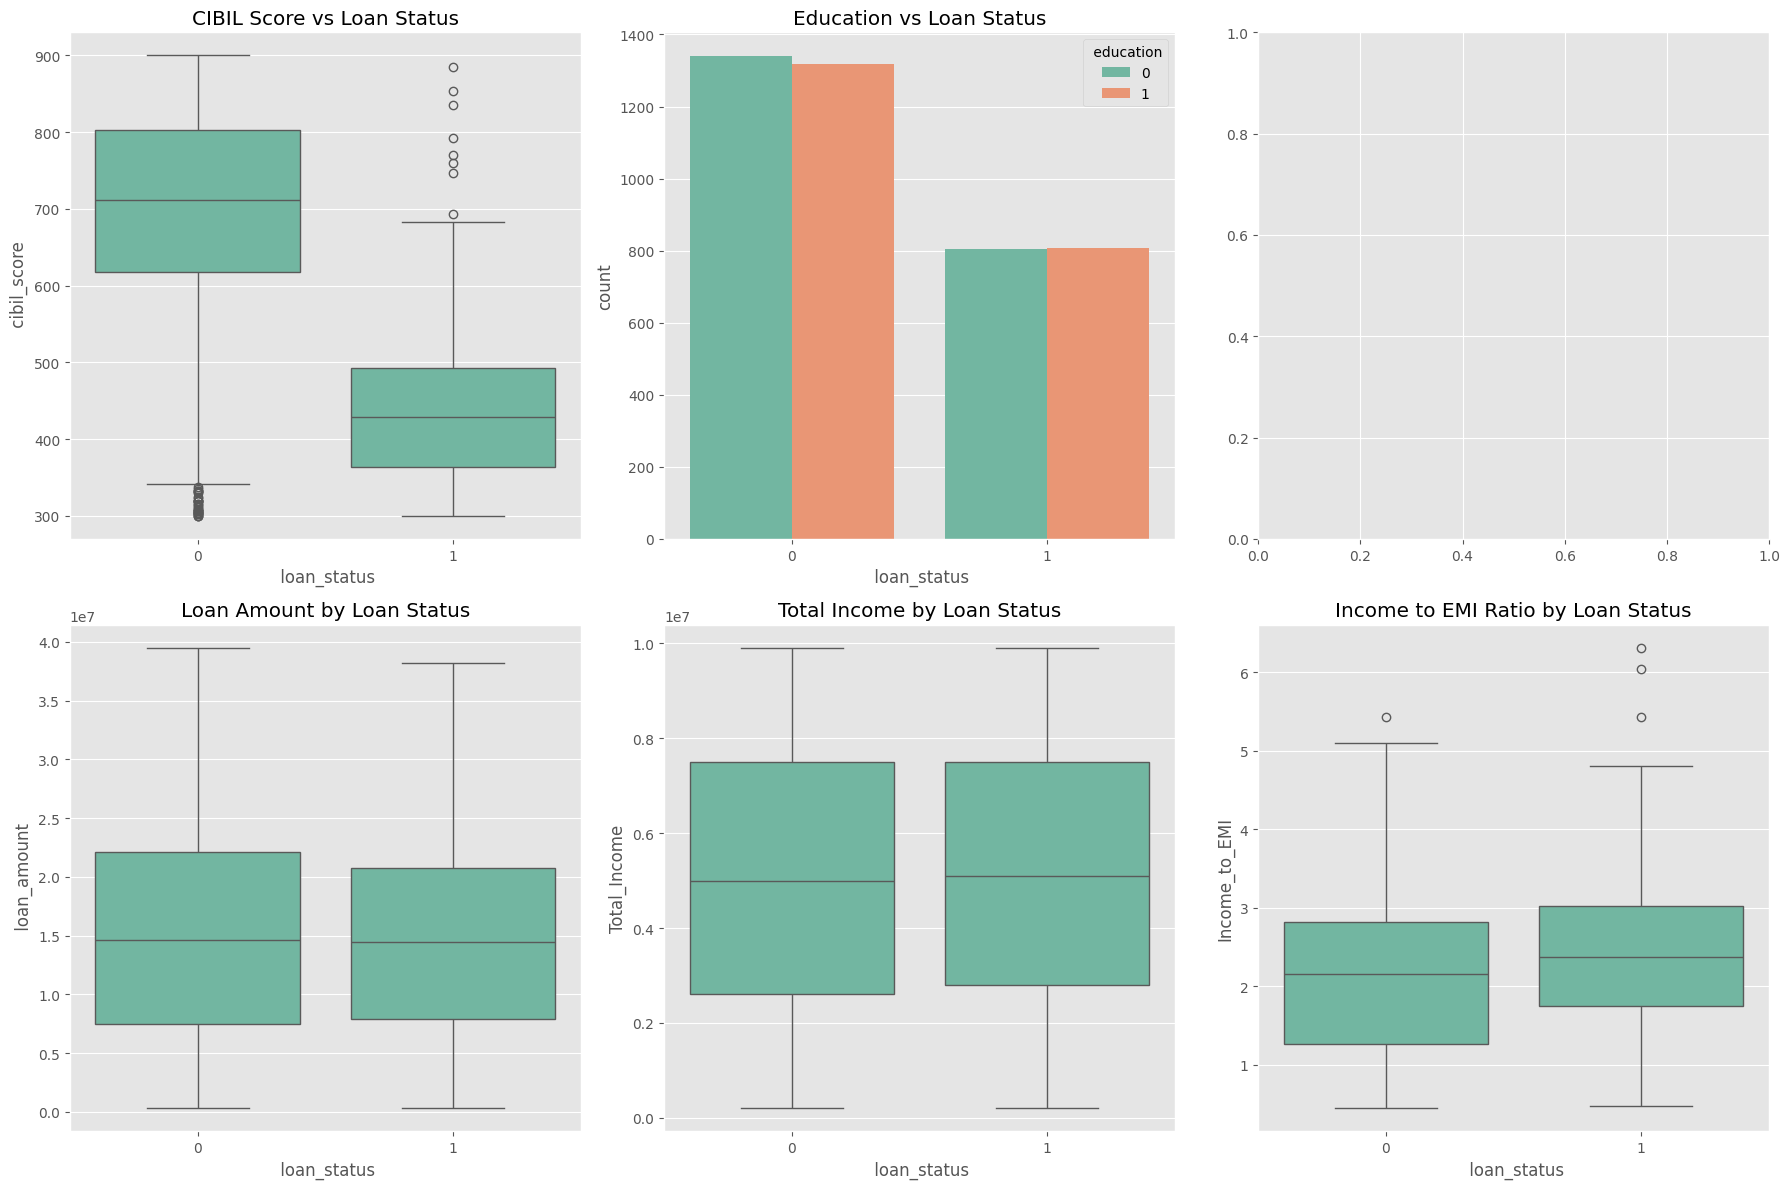

In [ ]:
# Visualize the target variable distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=' loan_status', data=df_processed)
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status (0: Rejected, 1: Approved)')
plt.ylabel('Count')
plt.show()

# Check correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df_processed.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Plot relationships between key features and loan status
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Credit History vs Loan Status
# Assuming ' cibil_score' is used as Credit History
sns.boxplot(x=' loan_status', y=' cibil_score', data=df_processed, ax=axes[0, 0])
axes[0, 0].set_title('CIBIL Score vs Loan Status')

# Property Area vs Loan Status
# Based on available columns, there is no column related to 'Property_Area'.
# I will skip plotting Property_Area vs Loan Status.

# Education vs Loan Status
sns.countplot(x=' loan_status', hue=' education', data=df_processed, ax=axes[0, 1])
axes[0, 1].set_title('Education vs Loan Status')


# Loan Amount distribution by Loan Status
sns.boxplot(x=' loan_status', y=' loan_amount', data=df_processed, ax=axes[1, 0])
axes[1, 0].set_title('Loan Amount by Loan Status')

# Total Income distribution by Loan Status
sns.boxplot(x=' loan_status', y='Total_Income', data=df_processed, ax=axes[1, 1])
axes[1, 1].set_title('Total Income by Loan Status')

# Income to EMI ratio by Loan Status
sns.boxplot(x=' loan_status', y='Income_to_EMI', data=df_processed, ax=axes[1, 2])
axes[1, 2].set_title('Income to EMI Ratio by Loan Status')

plt.tight_layout()
plt.show()

In [ ]:
# Separate features and target
X = df_processed.drop([' loan_status', 'loan_id'], axis=1)  # Drop Loan_ID as it's just an identifier
y = df_processed[' loan_status']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Class distribution in training set: {np.bincount(y_train)}")
print(f"Class distribution in test set: {np.bincount(y_test)}")

Training set shape: (3415, 15)
Test set shape: (854, 15)
Class distribution in training set: [2125 1290]
Class distribution in test set: [531 323]


In [ ]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Train and evaluate baseline models
baseline_results = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    # Store results
    baseline_results[name] = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'model': model
    }

    # Print results
    print(f"\n{name} Results:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    if roc_auc is not None:
        print(f"ROC-AUC: {roc_auc:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


Logistic Regression Results:
Precision: 0.9408
Recall: 0.8854
F1-Score: 0.9123
ROC-AUC: 0.9773

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       531
           1       0.94      0.89      0.91       323

    accuracy                           0.94       854
   macro avg       0.94      0.93      0.93       854
weighted avg       0.94      0.94      0.94       854


Decision Tree Results:
Precision: 0.9969
Recall: 0.9907
F1-Score: 0.9938
ROC-AUC: 0.9944

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       531
           1       1.00      0.99      0.99       323

    accuracy                           1.00       854
   macro avg       1.00      0.99      1.00       854
weighted avg       1.00      1.00      1.00       854


Random Forest Results:
Precision: 1.0000
Recall: 0.9876
F1-Score: 0.9938
ROC-AUC: 0.9986

Classification Report

In [ ]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"Class distribution before SMOTE: {np.bincount(y_train)}")
print(f"Class distribution after SMOTE: {np.bincount(y_train_smote)}")

# Train and evaluate models with SMOTE
smote_results = {}

for name, model in models.items():
    # Create a new instance of the model
    if name == 'Logistic Regression':
        current_model = LogisticRegression(random_state=42, max_iter=1000)
    elif name == 'Decision Tree':
        current_model = DecisionTreeClassifier(random_state=42)
    else:
        current_model = RandomForestClassifier(random_state=42)

    # Train the model with SMOTE data
    current_model.fit(X_train_smote, y_train_smote)

    # Make predictions
    y_pred = current_model.predict(X_test_scaled)
    y_pred_proba = current_model.predict_proba(X_test_scaled)[:, 1] if hasattr(current_model, "predict_proba") else None

    # Calculate metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    # Store results
    smote_results[name] = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'model': current_model
    }

    # Print results
    print(f"\n{name} with SMOTE Results:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    if roc_auc is not None:
        print(f"ROC-AUC: {roc_auc:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

Class distribution before SMOTE: [2125 1290]
Class distribution after SMOTE: [2125 2125]

Logistic Regression with SMOTE Results:
Precision: 0.9308
Recall: 0.9164
F1-Score: 0.9236
ROC-AUC: 0.9776

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       531
           1       0.93      0.92      0.92       323

    accuracy                           0.94       854
   macro avg       0.94      0.94      0.94       854
weighted avg       0.94      0.94      0.94       854


Decision Tree with SMOTE Results:
Precision: 0.9938
Recall: 0.9907
F1-Score: 0.9922
ROC-AUC: 0.9935

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       531
           1       0.99      0.99      0.99       323

    accuracy                           0.99       854
   macro avg       0.99      0.99      0.99       854
weighted avg       0.99      0.99      0.99       854




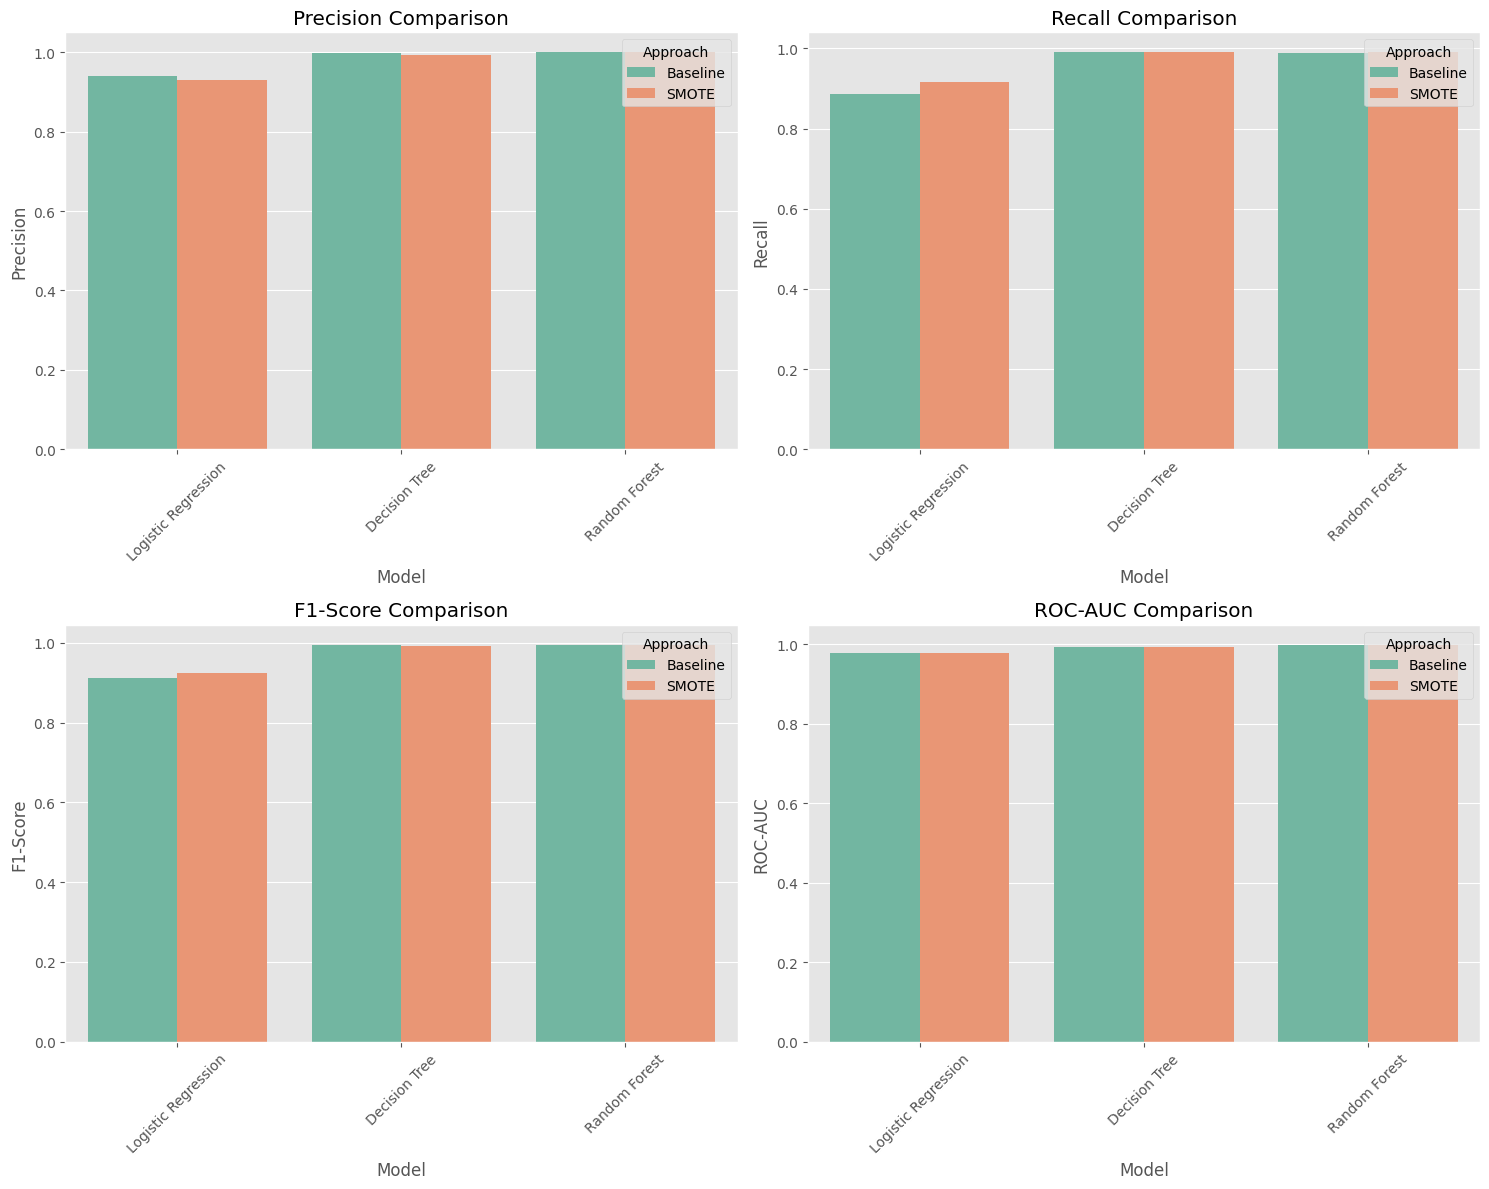

Model Comparison:
                              Precision    Recall  F1-Score   ROC-AUC
Model               Approach                                         
Decision Tree       Baseline   0.996885  0.990712  0.993789  0.994414
                    SMOTE      0.993789  0.990712  0.992248  0.993473
Logistic Regression Baseline   0.940789  0.885449  0.912281  0.977325
                    SMOTE      0.930818  0.916409  0.923557  0.977588
Random Forest       Baseline   1.000000  0.987616  0.993769  0.998560
                    SMOTE      1.000000  0.990712  0.995334  0.999295


In [ ]:
# Create comparison DataFrame
comparison_data = []
for model_name in models.keys():
    comparison_data.append({
        'Model': model_name,
        'Approach': 'Baseline',
        'Precision': baseline_results[model_name]['precision'],
        'Recall': baseline_results[model_name]['recall'],
        'F1-Score': baseline_results[model_name]['f1'],
        'ROC-AUC': baseline_results[model_name]['roc_auc']
    })
    comparison_data.append({
        'Model': model_name,
        'Approach': 'SMOTE',
        'Precision': smote_results[model_name]['precision'],
        'Recall': smote_results[model_name]['recall'],
        'F1-Score': smote_results[model_name]['f1'],
        'ROC-AUC': smote_results[model_name]['roc_auc']
    })

comparison_df = pd.DataFrame(comparison_data)

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

metrics = ['Precision', 'Recall', 'F1-Score', 'ROC-AUC']
for i, metric in enumerate(metrics):
    row, col = i // 2, i % 2
    sns.barplot(x='Model', y=metric, hue='Approach', data=comparison_df, ax=axes[row, col])
    axes[row, col].set_title(f'{metric} Comparison')
    axes[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Display numerical comparison
print("Model Comparison:")
print(comparison_df.groupby(['Model', 'Approach']).mean())

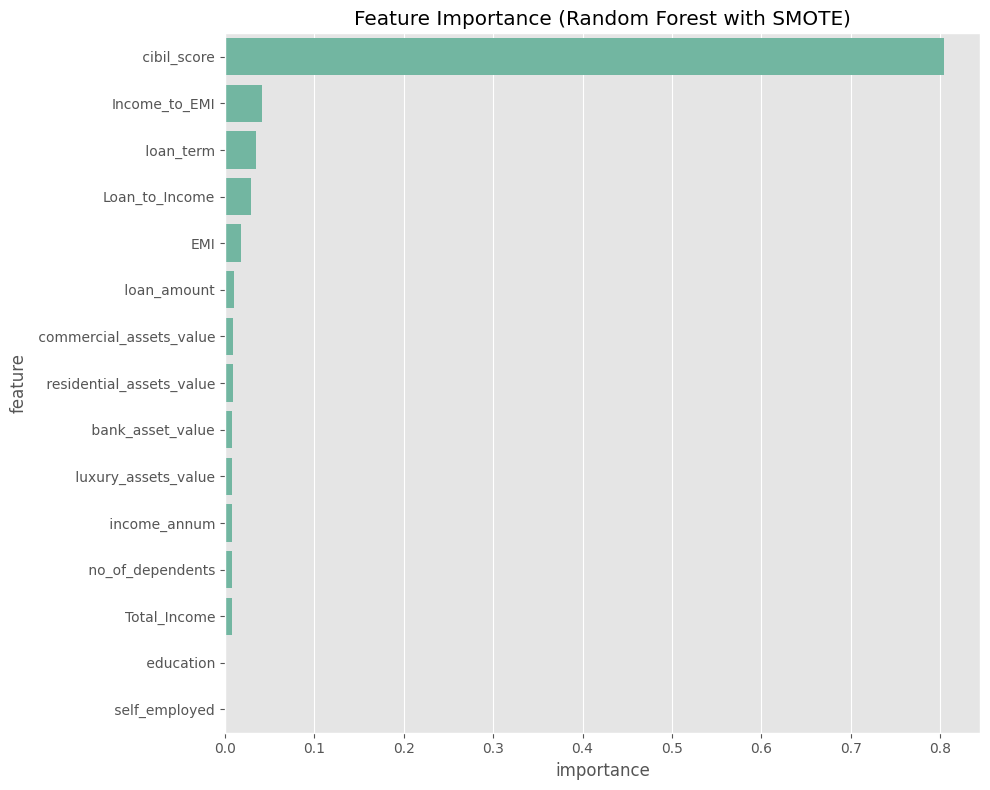

Top 10 Most Important Features:
                      feature  importance
6                 cibil_score    0.804245
13              Income_to_EMI    0.041266
5                   loan_term    0.034409
14             Loan_to_Income    0.029624
12                        EMI    0.018172
4                 loan_amount    0.010591
8     commercial_assets_value    0.009613
7    residential_assets_value    0.009343
10           bank_asset_value    0.008397
9         luxury_assets_value    0.008054


In [ ]:
# Get feature importance from the best model (Random Forest with SMOTE)
best_model = smote_results['Random Forest']['model']
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance (Random Forest with SMOTE)')
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

In [ ]:
# Cross-validation for the best model
best_model_cv = RandomForestClassifier(random_state=42)

# Create pipeline with SMOTE and model
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', best_model_cv)
])

# Perform cross-validation
cv_scores = cross_val_score(pipeline, X_train_scaled, y_train, cv=5, scoring='f1')

print(f"Cross-Validation F1 Scores: {cv_scores}")
print(f"Mean F1 Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Cross-Validation F1 Scores: [0.99029126 0.99021526 0.99415205 0.99415205 0.99805825]
Mean F1 Score: 0.9934 (+/- 0.0058)


Final Model Evaluation:
Precision: 1.0000
Recall: 0.9907
F1-Score: 0.9953
ROC-AUC: 0.9993

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       531
           1       1.00      0.99      1.00       323

    accuracy                           1.00       854
   macro avg       1.00      1.00      1.00       854
weighted avg       1.00      1.00      1.00       854



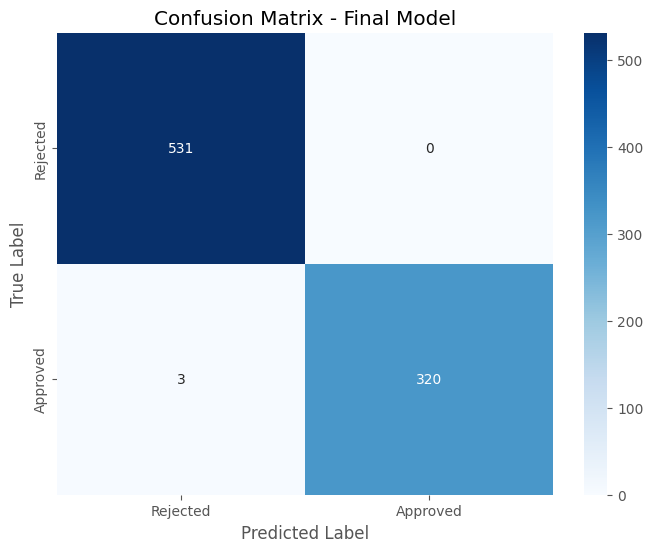

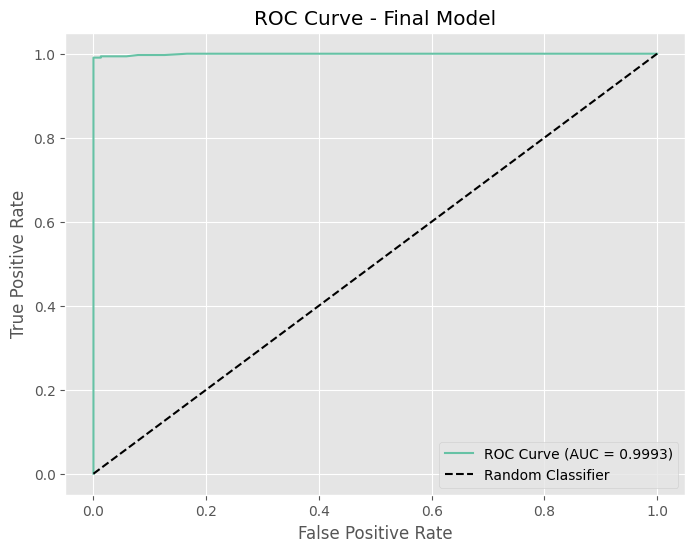

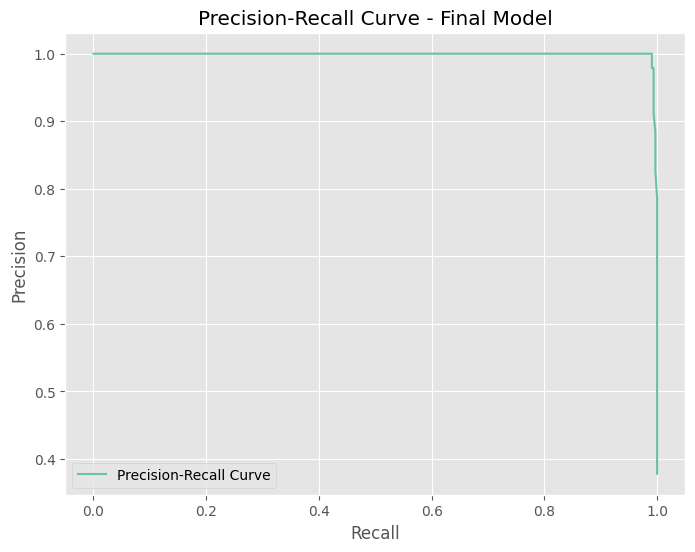

In [ ]:
# Train final model on full training data with SMOTE
final_model = RandomForestClassifier(random_state=42)
final_model.fit(X_train_smote, y_train_smote)

# Make predictions on test set
y_pred_final = final_model.predict(X_test_scaled)
y_pred_proba_final = final_model.predict_proba(X_test_scaled)[:, 1]

# Comprehensive evaluation
print("Final Model Evaluation:")
print("=" * 50)
print(f"Precision: {precision_score(y_test, y_pred_final):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_final):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_final):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_final):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_final))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'])
plt.title('Confusion Matrix - Final Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_final)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba_final):.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Final Model')
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_final)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Final Model')
plt.legend()
plt.show()